In [66]:
# Core
import os
import json
import glob

# Math & Data
import numpy as np
import pandas as pd
import random

# Visualization
import matplotlib.pyplot as plt

# Image Processing
import cv2

# Utilities
from pathlib import Path
from typing import List, Tuple, Dict
from collections import Counter


In [67]:
# CELL 1 — Imports & path setup

PROJECT_ROOT = Path.cwd().parent
DATA_ROOT    = PROJECT_ROOT / "data"
DATASET_DIR  = PROJECT_ROOT / "dataset"
ORIGINALS_DIR = DATA_ROOT / "originals"
CLEAN_DIR     = ORIGINALS_DIR / "clean"      
HEATMAPS_DIR  = ORIGINALS_DIR / "heatmaps"   
COMPRESSED_DIR = ORIGINALS_DIR / "compressed"
JSON_PATH     = DATA_ROOT / "LocJND.json"

# existing patch dirs (if used later in the notebook)
ORIG_PATCH_DIR  = DATASET_DIR / "orig_patches"
MIXED_PATCH_DIR = DATASET_DIR / "mixed_patches"

# ---- Core patch constants ----
PATCH_SIZE = 20
INNER_PATCH_SIZE = 12

print("DATA_ROOT     :", DATA_ROOT)
print("ORIGINALS_DIR :", ORIGINALS_DIR)
print("CLEAN_DIR     :", CLEAN_DIR)
print("HEATMAPS_DIR  :", HEATMAPS_DIR)
print("COMPRESSED_DIR:", COMPRESSED_DIR)
print("JSON_PATH     :", JSON_PATH)
print("ORIG_PATCH_DIR:", ORIG_PATCH_DIR)
print("MIXED_PATCH_DIR:", MIXED_PATCH_DIR)

DATA_ROOT     : c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\data
ORIGINALS_DIR : c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\data\originals
CLEAN_DIR     : c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\data\originals\clean
HEATMAPS_DIR  : c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\data\originals\heatmaps
COMPRESSED_DIR: c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\data\originals\compressed
JSON_PATH     : c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\data\LocJND.json
ORIG_PATCH_DIR: c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\dataset\orig_patches
MIXED_PATCH_DIR: c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\dataset\mixed_

In [68]:
def annotate_and_build_heatmaps(images_dir: str,
                                json_name: str = "points_by_image.json",
                                sigma: int = 30,
                                alpha: float = 0.5,
                                output_suffix: str = "_HEAT.png"):
    """
    1) Iterates over all images in `images_dir` (png/jpg/jpeg/bmp).
    2) For each image, shows an interactive window to collect EXACTLY 3 points from the user.
       - Left click: add a point
       - Right click or key 'u': undo last point
       - Key 'r': reset points
       - Key 'q': quit early (no save for current)
       Once 3 points are set, the image auto-advances to the next one.
    3) Saves all collected points into a single JSON file in the same folder.
    4) After all images are annotated, generates a LocJND-style heatmap overlay for each image
       with sigma=30 and alpha=0.5 (configurable) and saves it next to the original.
    """

    # ------------- gather images -------------
    exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp")
    image_paths = []
    for e in exts:
        image_paths.extend(glob(os.path.join(images_dir, e)))
    image_paths.sort()
    if not image_paths:
        print("No images found in:", images_dir)
        return

    # ------------- interactive picker helpers -------------
    collected = []  # list of dicts: {"filename": str, "width": int, "height": int, "points": [{"x":..,"y":..}, ...]}

    max_win_w, max_win_h = 1400, 900  # display cap (image is still recorded in original resolution)

    def show_picker(img_bgr, title="Pick 3 points"):
        """
        Returns a list of 3 (x,y) pixel coordinates in ORIGINAL resolution.
        """
        h, w = img_bgr.shape[:2]
        scale = min(max_win_w / w, max_win_h / h, 1.0)
        disp = cv2.resize(img_bgr, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)

        pts = []

        def redraw():
            view = disp.copy()
            for i, (ox, oy) in enumerate(pts, 1):
                dx, dy = int(ox * scale), int(oy * scale)
                cv2.circle(view, (dx, dy), 8, (0, 0, 255), -1)
                cv2.putText(view, str(i), (dx + 10, dy - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            footer = "L: add  |  R/u: undo  |  r: reset  |  q: quit"
            cv2.rectangle(view, (0, view.shape[0]-30), (view.shape[1], view.shape[0]), (0,0,0), -1)
            cv2.putText(view, footer, (10, view.shape[0]-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
            cv2.imshow(title, view)

        def on_mouse(event, x, y, flags, param):
            nonlocal pts
            if event == cv2.EVENT_LBUTTONDOWN and len(pts) < 3:
                ox, oy = int(x / scale), int(y / scale)
                ox = max(0, min(w - 1, ox))
                oy = max(0, min(h - 1, oy))
                pts.append((ox, oy))
                redraw()
            elif event == cv2.EVENT_RBUTTONDOWN:
                if pts:
                    pts.pop()
                    redraw()

        cv2.namedWindow(title, cv2.WINDOW_AUTOSIZE)
        cv2.setMouseCallback(title, on_mouse)
        redraw()

        while True:
            k = cv2.waitKey(20) & 0xFF
            if k == ord('q'):
                pts = []  # empty to signal "skip"
                break
            elif k == ord('u'):
                if pts:
                    pts.pop()
                    redraw()
            elif k == ord('r'):
                pts = []
                redraw()
            # auto-advance when 3 points chosen
            if len(pts) == 3:
                break

        cv2.destroyWindow(title)
        return pts

    # ------------- pass 1: collect points -------------
    for idx, img_path in enumerate(image_paths, 1):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping unreadable file: {img_path}")
            continue

        base = os.path.basename(img_path)
        print(f"[{idx}/{len(image_paths)}] {base}: pick 3 points...")
        pts = show_picker(img, title=f"Pick 3 points: {base}")

        if len(pts) != 3:
            print(f"Skipped (no points) → {base}")
            continue

        h, w = img.shape[:2]
        collected.append({
            "filename": base,
            "width": w,
            "height": h,
            "points": [{"x": int(x), "y": int(y)} for (x, y) in pts]
        })

    # save JSON
    json_path = os.path.join(images_dir, json_name)
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump({"images": collected}, f, ensure_ascii=False, indent=2)
    print(f"Saved annotations → {json_path}")

    # ------------- pass 2: build heatmaps -------------
    def build_heat_overlay(img_bgr, points_xy, sigma_px=30, alpha_overlay=0.6):
        h, w = img_bgr.shape[:2]
        heat = np.zeros((h, w), dtype=np.float32)
        xs = np.arange(0, w)
        ys = np.arange(0, h)
        X, Y = np.meshgrid(xs, ys)

        for (x, y) in points_xy:
            g = np.exp(-((X - x) ** 2 + (Y - y) ** 2) / (2.0 * (sigma_px ** 2)))
            heat += g

        if heat.max() > 0:
            heat /= heat.max()

        heat_u8 = (heat * 255).astype(np.uint8)
        colored = cv2.applyColorMap(heat_u8, cv2.COLORMAP_JET)  # BGR
        overlay = cv2.addWeighted(img_bgr, 1.0 - alpha_overlay, colored, alpha_overlay, 0)
        return overlay

    for entry in collected:
        img_path = os.path.join(images_dir, entry["filename"])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Missing image for heatmap: {img_path}")
            continue

        pts_xy = [(p["x"], p["y"]) for p in entry["points"]]
        overlay = build_heat_overlay(img, pts_xy, sigma_px=sigma, alpha_overlay=alpha)

        out_name = os.path.splitext(entry["filename"])[0] + output_suffix
        out_path = os.path.join(images_dir, out_name)
        cv2.imwrite(out_path, overlay)
        print(f"Saved heatmap → {out_path}")

    print("Done.")


In [69]:
#annotate_and_build_heatmaps(
#    images_dir=str(ORIGINALS_DIR),
#    json_name="points_by_image.json",
#    sigma=30,
#    alpha=0.5,
#    output_suffix="_HEAT.png"
#)

In [70]:
def collect_points_from_heatmaps(heatmaps_dir: str,
                                 json_name: str = "heatmap_points.json",
                                 require_name_contains: str = "HEAT"):
    """
    Iterate over all heatmap images in a folder, display each, and let the user click EXACTLY 3 points.
    Saves all points into a single JSON file at the end.

    Controls:
      - Left click: add a point (max 3)
      - Right click or key 'u': undo last point
      - Key 'r': reset current image's points
      - Key 'q': quit early (keeps progress so far)

    Args:
        heatmaps_dir: Path to a directory containing heatmap images.
        json_name: Output JSON filename (saved inside heatmaps_dir).
        require_name_contains: Only files containing this substring are considered (set to "" to disable).
    """
    # ---- collect candidate image paths ----
    exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp")
    paths = []
    for e in exts:
        paths.extend(glob(os.path.join(heatmaps_dir, e)))
    # keep only files that look like heatmaps (default: filename contains "HEAT")
    if require_name_contains:
        paths = [p for p in paths if require_name_contains.lower() in os.path.basename(p).lower()]
    paths.sort()

    if not paths:
        print("No heatmap images found in:", heatmaps_dir)
        return

    # display size cap; coordinates are always saved in ORIGINAL resolution
    MAX_W, MAX_H = 1400, 900

    annotations = []  # [{"filename": ..., "width": w, "height": h, "points": [{"x":..,"y":..}, ...]}]

    def pick_points(img_bgr, window_title):
        """Return up to 3 points (x,y) in ORIGINAL pixel coordinates."""
        h, w = img_bgr.shape[:2]
        scale = min(MAX_W / w, MAX_H / h, 1.0)
        disp = cv2.resize(img_bgr, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)

        pts = []

        def redraw():
            view = disp.copy()
            for i, (ox, oy) in enumerate(pts, 1):
                dx, dy = int(ox * scale), int(oy * scale)
                cv2.circle(view, (dx, dy), 8, (0, 0, 255), -1)
                cv2.putText(view, str(i), (dx + 10, dy - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            footer = "L=add  R/u=undo  r=reset  q=quit"
            cv2.rectangle(view, (0, view.shape[0]-30), (view.shape[1], view.shape[0]), (0,0,0), -1)
            cv2.putText(view, footer, (10, view.shape[0]-8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
            cv2.imshow(window_title, view)

        def on_mouse(event, x, y, flags, param):
            nonlocal pts
            if event == cv2.EVENT_LBUTTONDOWN and len(pts) < 3:
                ox, oy = int(x / scale), int(y / scale)
                ox = max(0, min(w - 1, ox))
                oy = max(0, min(h - 1, oy))
                pts.append((ox, oy))
                redraw()
            elif event == cv2.EVENT_RBUTTONDOWN and pts:
                pts.pop()
                redraw()

        cv2.namedWindow(window_title, cv2.WINDOW_AUTOSIZE)
        cv2.setMouseCallback(window_title, on_mouse)
        redraw()

        while True:
            k = cv2.waitKey(20) & 0xFF
            if k == ord('q'):
                cv2.destroyWindow(window_title)
                return None  # signal early-quit
            elif k == ord('u') and pts:
                pts.pop(); redraw()
            elif k == ord('r'):
                pts = []; redraw()
            if len(pts) == 3:
                cv2.destroyWindow(window_title)
                return pts

    # ---- iterate over images ----
    for i, path in enumerate(paths, 1):
        img = cv2.imread(path)
        if img is None:
            print("Skipping unreadable:", path)
            continue

        title = f"[{i}/{len(paths)}] Pick 3 points: {os.path.basename(path)}"
        pts = pick_points(img, title)
        if pts is None:  # user pressed 'q'
            break

        h, w = img.shape[:2]
        annotations.append({
            "filename": os.path.basename(path),
            "width": w,
            "height": h,
            "points": [{"x": int(x), "y": int(y)} for (x, y) in pts]
        })

    # ---- save JSON ----
    out_json = os.path.join(heatmaps_dir, json_name)
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump({"images": annotations}, f, ensure_ascii=False, indent=2)

    print(f"Saved {len(annotations)} annotated image(s) → {out_json}")

In [71]:
#collect_points_from_heatmaps(
#    heatmaps_dir=str(HEATMAPS_DIR),
#    json_name="heatmap_points.json",
#    require_name_contains="HEAT"  # or "" if your heatmap names differ
#)

In [72]:
# CELL 2 — Load metadata from LocJND.json with points

with open(JSON_PATH, 'r') as f:
    metadata = json.load(f)

heat_images = []
for entry in metadata["dataset"]["images"]:
    if entry.get("heatmap_file") and entry["set_type"] == "test":
        # default no points
        points = []
        if "heatmap_points" in entry and "points" in entry["heatmap_points"]:
            points = [(p["x"], p["y"]) for p in entry["heatmap_points"]["points"]]

        # FIXED: Use correct directory structure
        # Reference files are in data/originals/clean/
        # Heatmap files are in data/originals/heatmaps/
        # Compressed files are in data/originals/compressed/
        reference_file = ORIGINALS_DIR / "clean" / entry["reference_file"]
        heatmap_file = ORIGINALS_DIR / "heatmaps" / entry["heatmap_file"]
        compressed_file = ORIGINALS_DIR / "compressed" / entry["sample_distortion_filename"]

        heat_images.append({
            "image_id": entry["image_id"],
            "reference_file": str(reference_file),
            "heatmap_file": str(heatmap_file),
            "compressed_file": str(compressed_file),
            "codec": entry.get("codec", ""),
            "points": points
        })

print(f"Found {len(heat_images)} images with HEATMAPs.")
display(pd.DataFrame(heat_images))


Found 4 images with HEATMAPs.


image_id                                     reference_file  \
0  Test_SRC0027  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
1  Test_SRC0045  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
2  Test_SRC0058  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
3  Test_SRC0100  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   

                                        heatmap_file  \
0  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
1  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
2  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
3  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   

                                     compressed_file codec  \
0  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...  JPEG   
1  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...  JPEG   
2  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   BPG   
3  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   PNG   

                                points  
0  [(111, 262), (450, 41), (566, 434)]  
1   [(22, 49), (189, 319), (592, 304)]  
2    [(14, 58), (52, 428), (498, 394)]  
3  [(109, 144), (379, 50), (373, 353)]


=== Test_SRC0027 | codec: JPEG ===


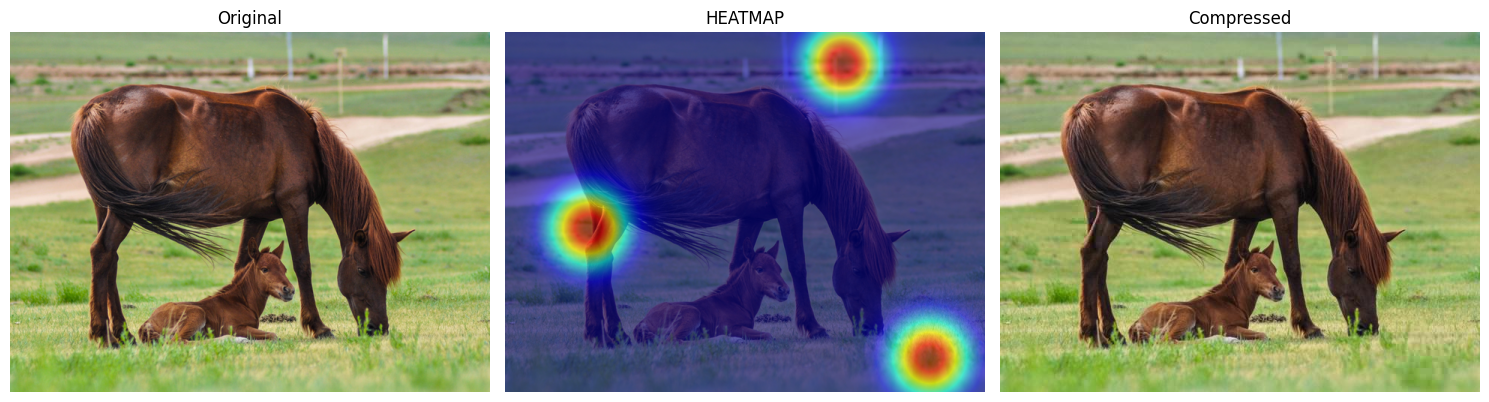


=== Test_SRC0045 | codec: JPEG ===


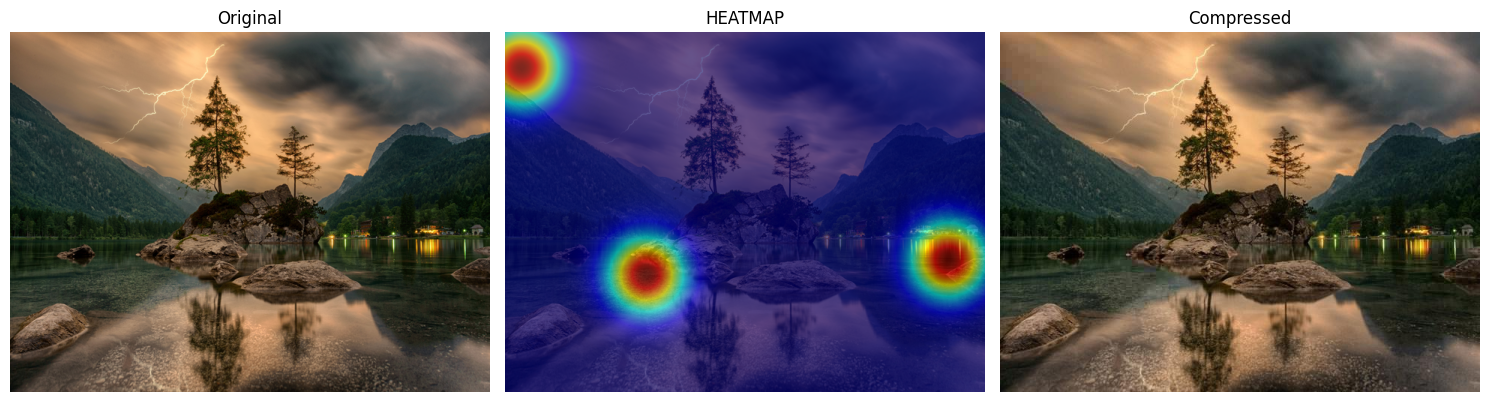


=== Test_SRC0058 | codec: BPG ===


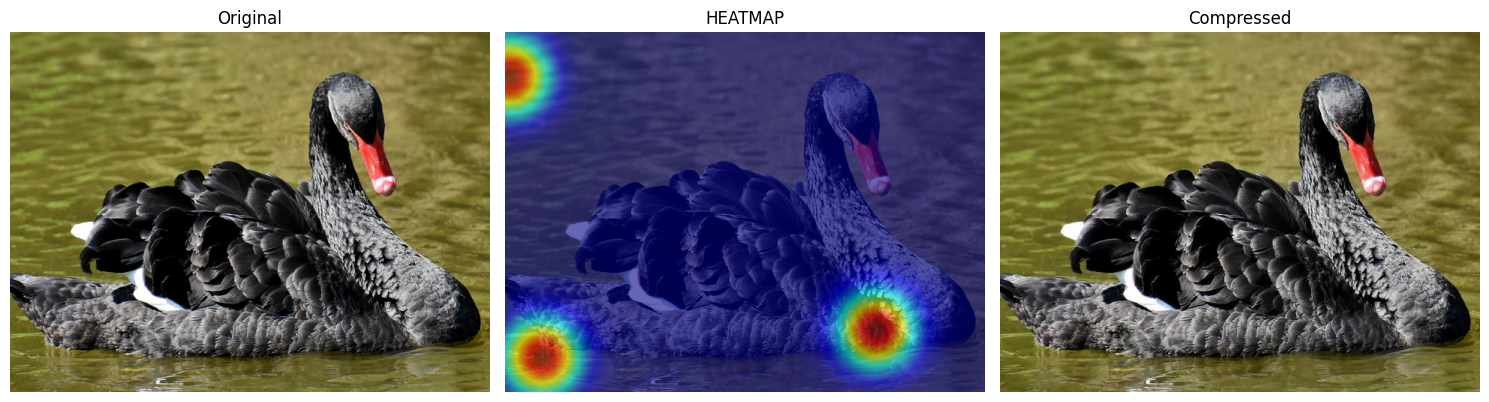


=== Test_SRC0100 | codec: PNG ===


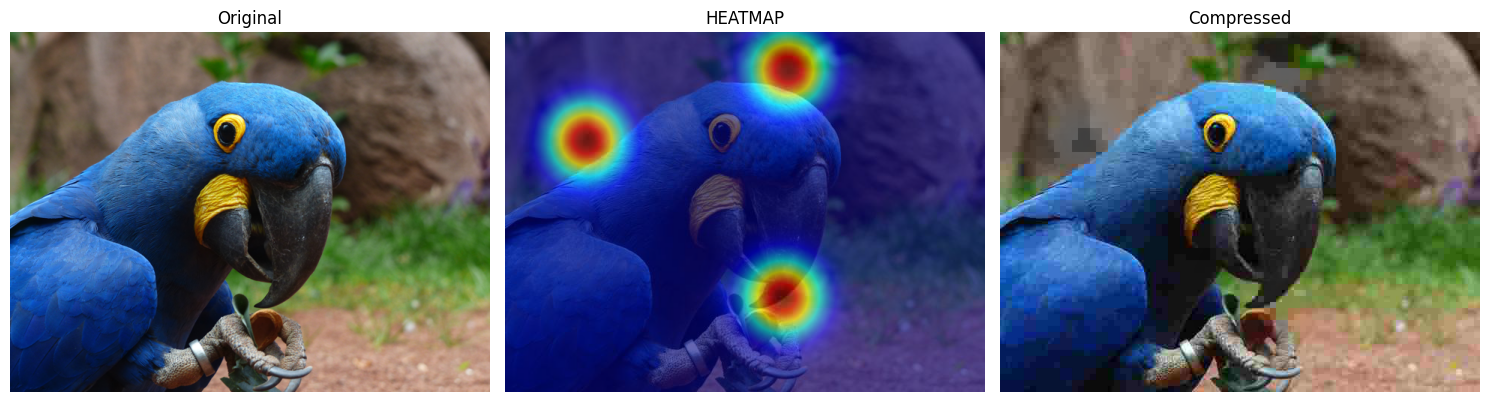

In [73]:
# CELL 3 — Show all TEST triplets (Original, HEATMAP, Compressed) using OpenCV

def show_images(imgs, titles=None, figsize=(15,5)):
    n = len(imgs)
    fig, axes = plt.subplots(1, n, figsize=(figsize[0], figsize[1]))
    if n == 1: axes = [axes]
    for ax, im, t in zip(axes, imgs, titles or [None]*n):
        if im is None:
            ax.set_title("Missing"); ax.axis("off"); continue
        ax.imshow(im); ax.axis("off")
        if t: ax.set_title(t)
    plt.tight_layout(); plt.show()

for t in heat_images:
    # Read with cv2 (BGR) then convert to RGB to match old notebook behavior
    orig = cv2.imread(t["reference_file"])
    heat = cv2.imread(t["heatmap_file"])
    comp = cv2.imread(t["compressed_file"])

    # Guard if any are missing
    if orig is None:
        print("Missing reference:", t["reference_file"]); continue
    if heat is None:
        print("Missing heatmap:", t["heatmap_file"])
    if comp is None:
        print("Missing compressed:", t["compressed_file"])

    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB) if heat is not None else None
    comp = cv2.cvtColor(comp, cv2.COLOR_BGR2RGB) if comp is not None else None

    print(f"\n=== {t['image_id']} | codec: {t.get('codec','')} ===")
    show_images([orig, heat, comp], titles=["Original", "HEATMAP", "Compressed"])


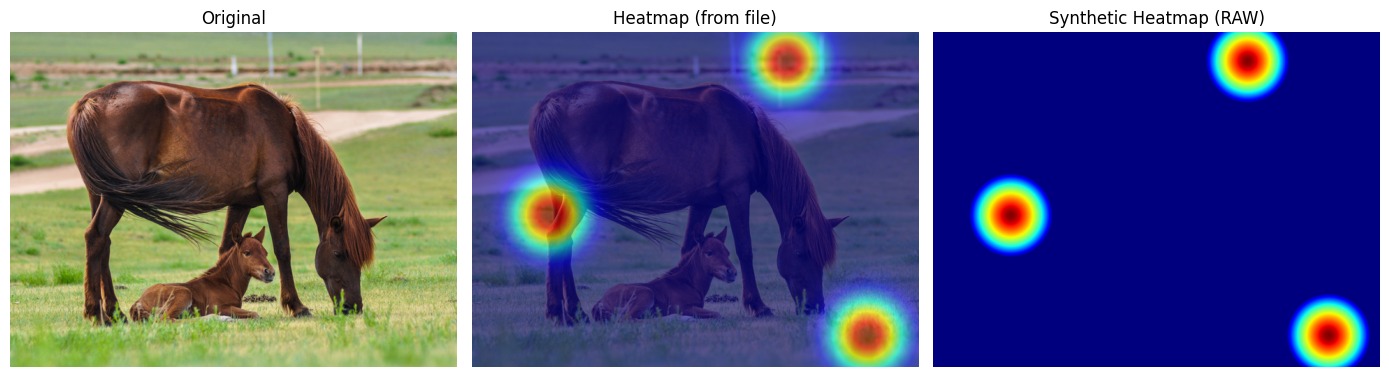

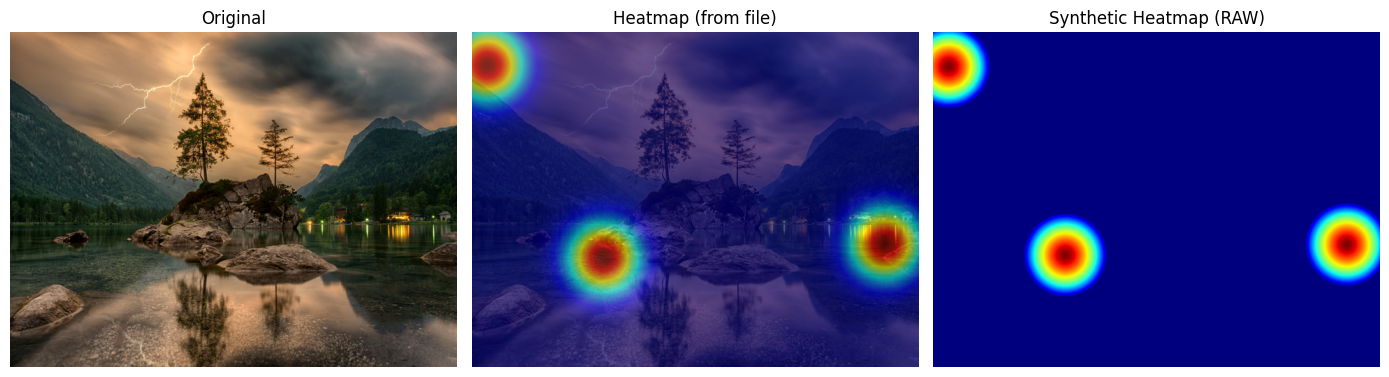

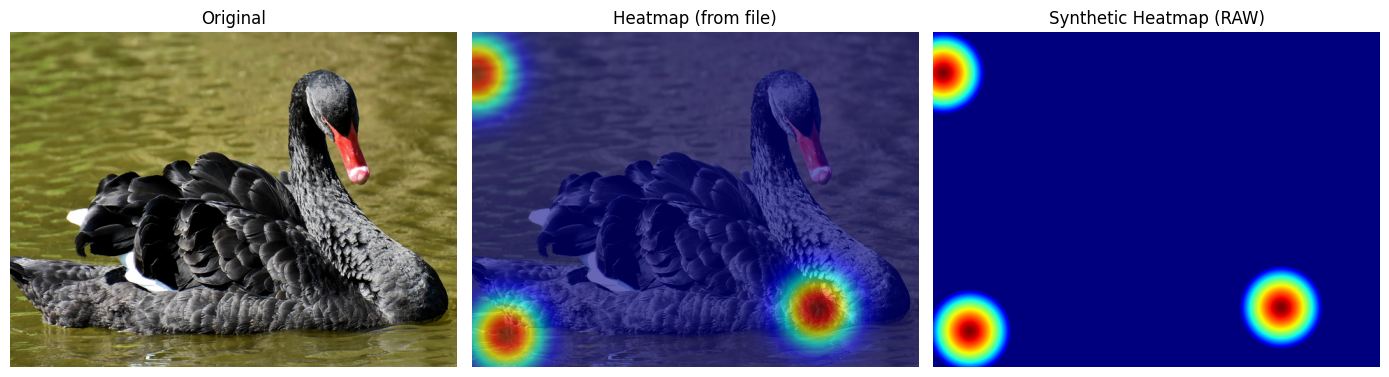

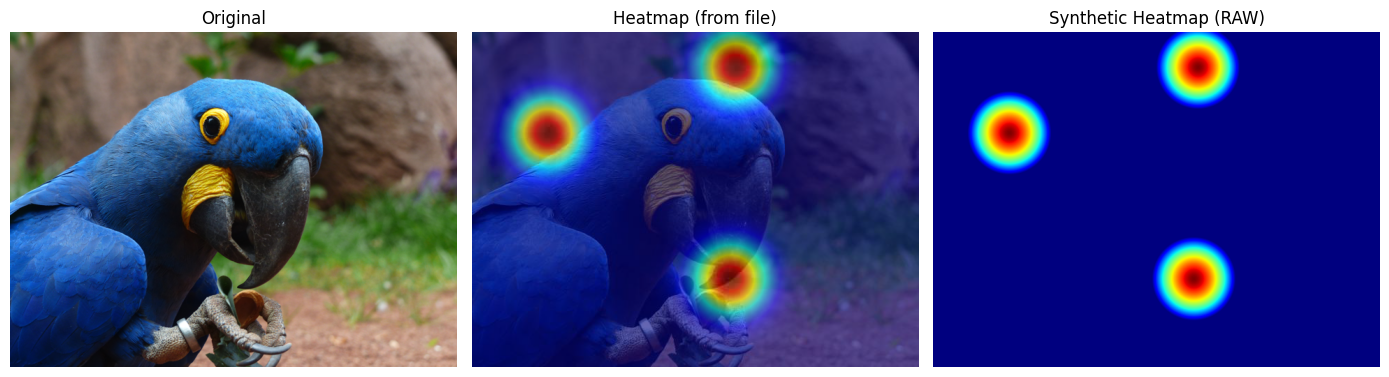

In [74]:
# CELL 4 — Visualize Original, Existing Heatmap, and Synthetic Heatmap
# Goal: Turn JSON points into a smooth synthetic heatmap and show side-by-side:
# [Original] | [Heatmap (from file, if exists)] | [Synthetic Heatmap (RAW, colorized)]
# Change: additionally cache per-image synthetic heatmaps for reuse in Cell 5.

# ---- Tunables ----
RADIUS_PX   = 60
GAMMA_DECAY = 1.6
COMB_MODE   = "max"

# Reusable cache for downstream cells (e.g., Cell 5)
heatmaps: dict[str, np.ndarray] = {}

def _scale_points(points_xy: List[Tuple[int,int]],
                  src_wh: Tuple[int,int] | None,
                  dst_hw: Tuple[int,int]) -> List[Tuple[int,int]]:
    if not src_wh or src_wh[0] <= 0 or src_wh[1] <= 0:
        return [(int(x), int(y)) for (x, y) in points_xy]
    json_w, json_h = src_wh
    H, W = dst_hw
    sx, sy = W / float(json_w), H / float(json_h)
    pts = [(int(round(x * sx)), int(round(y * sy))) for (x, y) in points_xy]
    return [(min(max(0, x), W - 1), min(max(0, y), H - 1)) for (x, y) in pts]

def _radial_field(shape_hw: Tuple[int,int], center_xy: Tuple[int,int],
                  R: float, gamma: float) -> np.ndarray:
    H, W = shape_hw
    x, y = center_xy
    yy, xx = np.ogrid[:H, :W]
    r = np.sqrt((yy - y)**2 + (xx - x)**2)
    with np.errstate(invalid='ignore'):
        h = 1.0 - np.power(r / max(R, 1e-6), gamma)
    h[r > R] = 0.0
    return np.clip(h, 0.0, 1.0).astype(np.float32)

def _combine(fields: List[np.ndarray], mode: str) -> np.ndarray:
    if not fields:
        return None
    stack = np.stack(fields, axis=0)
    if mode == "max":
        out = np.max(stack, axis=0)
    elif mode == "sum":
        out = np.sum(stack, axis=0)
        m = out.max()
        if m > 0:
            out /= m
    return out.astype(np.float32)

def _colorize01(hmap01: np.ndarray, cmap_name: str = "jet") -> np.ndarray:
    cmap = plt.colormaps[cmap_name]
    return (cmap(np.clip(hmap01, 0.0, 1.0))[:, :, :3] * 255).astype(np.uint8)

# ---- Main visualization ----
for rec in heat_images:
    orig_bgr = cv2.imread(rec["reference_file"])
    heat_bgr = cv2.imread(rec["heatmap_file"]) if rec.get("heatmap_file") else None
    if orig_bgr is None:
        continue

    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
    H, W = orig_rgb.shape[:2]

    # Existing heatmap (if available)
    if heat_bgr is not None:
        heat_bgr = cv2.resize(heat_bgr, (W, H))
        heat_rgb = cv2.cvtColor(heat_bgr, cv2.COLOR_BGR2RGB)
    else:
        heat_rgb = np.zeros_like(orig_rgb)

    # Synthetic from JSON points
    pts_xy = rec.get("points", [])
    json_size = rec.get("json_size", None)
    pts = _scale_points(pts_xy, json_size, (H, W))
    fields = [_radial_field((H, W), (x, y), RADIUS_PX, GAMMA_DECAY) for (x, y) in pts] if pts else []
    hmap01 = _combine(fields, COMB_MODE) if fields else np.zeros((H, W), np.float32)
    synth_rgb = _colorize01(hmap01, "jet")

    # Cache synthetic heatmap for downstream use (e.g., Cell 5)
    heatmaps[rec["image_id"]] = hmap01

    # Show triplet
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    for ax, img, title in zip(
        axes,
        [orig_rgb, heat_rgb, synth_rgb],
        ["Original", "Heatmap (from file)", "Synthetic Heatmap (RAW)"]
    ):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [75]:
# CELL 5 — Sample HOT/COLD patches from cached synthetic heatmaps
# ------------------------------------------------------------------------------
# Purpose
#   Use the per-image synthetic heatmaps cached in Cell 4 (`heatmaps[image_id]`)
#   to sample HOT/COLD patches from the ORIGINAL image and write metadata.
#
# Inputs (expected)
#   - heat_images: list of records with keys: image_id, reference_file, points, json_size (opt)
#   - heatmaps: dict[str, np.ndarray] produced in Cell 4 (H×W float32 in [0,1])
#   - PATCH_SIZE (odd int), DATA_ROOT (Path)
#
# Outputs
#   - {DATASET_DIR}/orig_patches/*.png
#   - {DATASET_DIR}/patches_meta.csv
#
# Notes
#   - No re-computation of heatmaps here; we consume `heatmaps`.
#   - No compressed usage, no blending, no overlays — focused on sampling only.
# ------------------------------------------------------------------------------

# ---- Tunables for sampling ----
N_BINS          = 8            # radial ring bins (for metadata)
HOT_THRESH      = 0.45         # min heat for HOT region
COLD_THRESH     = 0.05         # max heat for COLD region
N_HOT_PER_IMG   = 40           # target HOT patches per image
N_COLD_PER_IMG  = 16           # target COLD patches per image
BORDER_SAFE     = PATCH_SIZE // 2      # keep patch fully inside image
MIN_CENTER_DIST = 8            # min L2 distance between chosen centers (pixels)

# ---- Outputs ----
META_CSV = DATASET_DIR / "patches_meta.csv"

# ---- Local helpers (patch-only; no duplication with Cell 4) ----
def _extract_patch(img: np.ndarray, center_xy: Tuple[int, int], size: int) -> np.ndarray:
    """Return a (size x size) RGB crop centered at (x,y). Assumes border checks upstream."""
    x, y = center_xy
    r = size // 2
    return img[y - r:y + r, x - r:x + r].copy()

def _l2(a: Tuple[int,int], b: Tuple[int,int]) -> float:
    ax, ay = a; bx, by = b
    return float(np.hypot(ax - bx, ay - by))

def _coords_from_mask(mask: np.ndarray) -> List[Tuple[int,int]]:
    """Convert HxW boolean mask to list of (x,y) coordinates."""
    ys, xs = np.where(mask)
    return list(zip(xs.tolist(), ys.tolist()))

def _pick_centers(mask_coords: List[Tuple[int,int]], how_many: int, min_dist: int) -> List[Tuple[int,int]]:
    """Greedy selection of well-spaced centers (randomized order, L2 spacing)."""
    chosen: List[Tuple[int,int]] = []
    random.shuffle(mask_coords)
    for (x, y) in mask_coords:
        if all(_l2((x, y), c) >= min_dist for c in chosen):
            chosen.append((x, y))
            if len(chosen) >= how_many:
                break
    return chosen

def _compute_ring_index(x: int, y: int, centers_xy: List[Tuple[int,int]], R: int, n_bins: int) -> int:
    """Assign a patch to a radial ring bin (0...n_bins-1) based on distance to nearest JSON center."""
    if not centers_xy:
        return n_bins - 1
    r_min = min(_l2((x, y), (cx, cy)) for (cx, cy) in centers_xy)
    r_norm = np.clip(r_min / float(max(R, 1e-6)), 0.0, 0.999)  # keep in [0,1)
    return int(np.floor(r_norm * n_bins))

# ---- Main sampling routine ----
def _sample_patches_for_image(rec: Dict) -> List[Dict]:
    """Produce rows of metadata for the HOT/COLD patches of a single image record."""
    image_id = rec["image_id"]

    # Require cached heatmap from Cell 4
    if image_id not in heatmaps:
        # Fail fast to avoid silent re-computation and code duplication
        raise RuntimeError(f"Missing cached heatmap for image_id={image_id}. Run Cell 4 first.")

    heat_syn = heatmaps[image_id]  # float32 [0,1], shape H×W
    orig_bgr = cv2.imread(rec["reference_file"])
    if orig_bgr is None:
        return []

    orig = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
    H, W = orig.shape[:2]

    # Safety: ensure heatmap matches the image size
    if heat_syn.shape != (H, W):
        heat_syn = cv2.resize(heat_syn, (W, H), interpolation=cv2.INTER_LINEAR).astype(np.float32)
        heat_syn = np.clip(heat_syn, 0.0, 1.0)
        ax.axis("off")
    # Safe border mask (avoid crops crossing the image boundary)
    yy, xx = np.ogrid[:H, :W]
    safe_border = (xx >= BORDER_SAFE) & (xx < W - BORDER_SAFE) & (yy >= BORDER_SAFE) & (yy < H - BORDER_SAFE)

    # HOT / COLD masks
    hot_mask  = (heat_syn >= HOT_THRESH)  & safe_border
    cold_mask = (heat_syn <= COLD_THRESH) & safe_border

    hot_coords  = _coords_from_mask(hot_mask)
    cold_coords = _coords_from_mask(cold_mask)

    # Fallback: relax thresholds if too few candidates
    if len(hot_coords) < N_HOT_PER_IMG // 2:
        hot_coords = _coords_from_mask((heat_syn >= HOT_THRESH * 0.8) & safe_border)
    if len(cold_coords) < N_COLD_PER_IMG // 2:
        cold_coords = _coords_from_mask((heat_syn <= COLD_THRESH * 1.2) & safe_border)

    # Pick well-spaced centers
    hot_centers  = _pick_centers(hot_coords,  N_HOT_PER_IMG,  MIN_CENTER_DIST)
    cold_centers = _pick_centers(cold_coords, N_COLD_PER_IMG, MIN_CENTER_DIST)

    # Crop and save patches; collect rows
    rows: List[Dict] = []
    pts_img = rec.get("points", [])  # for ring metadata only (JSON points in image coords if you used scale earlier)
    for kind, centers in (("hot", hot_centers), ("cold", cold_centers)):
        for i, (x, y) in enumerate(centers):
            patch = _extract_patch(orig, (x, y), PATCH_SIZE)
            if patch.shape[0] != PATCH_SIZE or patch.shape[1] != PATCH_SIZE:
                continue  # skip near borders just in case

            base = f"{image_id}_{kind}_{i:03d}_x{x}_y{y}"
            f_po = ORIG_PATCH_DIR / f"{base}.png"
            cv2.imwrite(str(f_po), cv2.cvtColor(patch, cv2.COLOR_RGB2BGR))

            rows.append({
                "image_id": image_id,
                "kind": kind,                  # "hot" | "cold"
                "x": x, "y": y,                # patch center
                "h_c": float(heat_syn[y, x]),  # heat value at center
                "ring": _compute_ring_index(x, y, pts_img, R=RADIUS_PX, n_bins=N_BINS),
                "patch_size": PATCH_SIZE,
                "orig_path": str(f_po),
                "radius_px": RADIUS_PX,
                "gamma_decay": GAMMA_DECAY,
                "combine_mode": COMB_MODE,
                "codec": rec.get("codec", "")
            })
    return rows

# ---- Run over all images and write CSV ----
all_rows: List[Dict] = []
for rec in heat_images:
    rows = _sample_patches_for_image(rec)
    all_rows.extend(rows)
    print(f"{rec['image_id']}: saved {len(rows)} patches")

df_meta = pd.DataFrame(all_rows)
df_meta.to_csv(META_CSV, index=False)
print(f"\nSaved metadata: {META_CSV}")
display(df_meta.head())
print(f"Total patches: {len(df_meta)} | HOT: {(df_meta['kind']=='hot').sum()} | COLD: {(df_meta['kind']=='cold').sum()}")


Test_SRC0027: saved 56 patches
Test_SRC0045: saved 56 patches
Test_SRC0058: saved 56 patches
Test_SRC0100: saved 56 patches

Saved metadata: c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\dataset\patches_meta.csv


image_id kind    x    y       h_c  ring  patch_size  \
0  Test_SRC0027  hot   83  276  0.646867     4          20   
1  Test_SRC0027  hot  476   54  0.686351     3          20   
2  Test_SRC0027  hot  600  442  0.579229     4          20   
3  Test_SRC0027  hot  453   48  0.963212     1          20   
4  Test_SRC0027  hot   92  237  0.645138     4          20   

                                           orig_path  radius_px  gamma_decay  \
0  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...         60          1.6   
1  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...         60          1.6   
2  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...         60          1.6   
3  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...         60          1.6   
4  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...         60          1.6   

  combine_mode codec  
0          max  JPEG  
1          max  JPEG  
2          max  JPEG  
3          max  JPEG  
4          max  JPEG

Total patches: 224 | HOT: 160 | COLD: 64


In [76]:
# CELL 6 — Create blended patches (inner mixing) using on-the-fly COMP crops (+ y = 1 − α)
# ---------------------------------------------------------------------------------------
# Purpose
#   Produce blended patches by mixing ORIGINAL patch (from disk) with a COMPRESSED patch
#   cropped on-the-fly from the full compressed image (no comp_path in CSV, no duplication).
#
# Inputs (expected)
#   - {DATASET_DIR}/patches_meta.csv  (from CELL 5) with: image_id, x, y, patch_size, kind, ring, h_c, orig_path
#   - Globals: DATA_ROOT, PATCH_SIZE, INNER_PATCH_SIZE, heat_images (with reference_file, compressed_file)
#
# Outputs
#   - {DATASET_DIR}/blend_patches/*.png
#   - {DATASET_DIR}/blends_meta.csv  (alpha, y, coords, paths, etc.)
#
# Notes
#   - No reliance on comp_path; we crop comp patches directly from the full compressed image per image_id.
#   - Label definition: y = 1 − α ; blended = α·orig + (1−α)·comp (inner square only).


# ---- Required globals sanity ----
for var in ("DATASET_DIR", "PATCH_SIZE", "INNER_PATCH_SIZE", "heat_images"):
    if var not in globals():
        raise RuntimeError(f"Missing global `{var}`. Please run previous cells.")

# ---- Tunables ----
ALPHAS: List[float] = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# ---- I/O ----
PATCH_META_CSV = DATASET_DIR / "patches_meta.csv"
BLENDS_CSV     = DATASET_DIR / "blends_meta.csv"

# ---- Helper reuse / minimal fallbacks ----
def _read_rgb(path: str) -> np.ndarray:
    bgr = cv2.imread(path)
    if bgr is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

if "_extract_patch" not in globals():
    def _extract_patch(img: np.ndarray, center_xy: Tuple[int,int], size: int) -> np.ndarray:
        x, y = center_xy
        r = size // 2
        return img[y - r:y + r, x - r:x + r].copy()

def _blend_inner_patch(orig: np.ndarray, comp: np.ndarray, alpha: float, inner_size: int) -> np.ndarray:
    """Blend ONLY the centered inner square (inner_size×inner_size)."""
    assert orig.shape == comp.shape, "orig/comp must share shape"
    H, W = orig.shape[:2]
    cx, cy = W // 2, H // 2
    r = inner_size // 2
    x0, y0 = max(0, cx - r), max(0, cy - r)
    x1, y1 = min(W, cx + r), min(H, cy + r)
    out = orig.copy().astype(np.float32)
    roi = alpha * orig[y0:y1, x0:x1].astype(np.float32) + (1.0 - alpha) * comp[y0:y1, x0:x1].astype(np.float32)
    out[y0:y1, x0:x1] = roi
    return np.clip(out, 0, 255).astype(np.uint8)

# ---- Load patch metadata ----
if not PATCH_META_CSV.exists():
    raise FileNotFoundError(f"Missing {PATCH_META_CSV}. Run CELL 5 first.")
df_patches = pd.read_csv(PATCH_META_CSV)
print(f"Loaded {len(df_patches)} patch rows.")

# Map image_id -> record (for file paths)
rec_by_id = {rec["image_id"]: rec for rec in heat_images}

all_rows: List[Dict] = []
saved = 0

# Load full compressed/ref images once per image_id
for image_id, g in df_patches.groupby("image_id"):
    rec = rec_by_id.get(image_id)
    if not rec or not rec.get("compressed_file"):
        print(f"[WARN] image_id={image_id}: missing compressed_file; skipping.")
        continue

    # Full images
    comp_full = _read_rgb(rec["compressed_file"])           # for on-the-fly comp crops
    # (Optional) load full original only if you want to re-crop original; here we read orig patch from disk.

    for _, row in g.iterrows():
        x, y = int(row["x"]), int(row["y"])
        ps = int(row["patch_size"]) if "patch_size" in row else int(PATCH_SIZE)
        kind = row.get("kind", "")
        ring = int(row.get("ring", -1))
        h_c  = float(row.get("h_c", np.nan))
        codec = row.get("codec", "")

        # Load original PATCH directly from disk (already saved in CELL 5)
        po = _read_rgb(row["orig_path"])
        if po.shape[:2] != (ps, ps):
            # Fallback: re-crop from full original if needed
            full_orig = _read_rgb(rec["reference_file"])
            po = _extract_patch(full_orig, (x, y), ps)

        # Crop compressed PATCH on-the-fly from the full compressed image
        Hc, Wc = comp_full.shape[:2]
        # Ensure center is valid; if sizes differ from original pipeline, you may need to resize comp_full first.
        pc = _extract_patch(comp_full, (x, y), ps)
        if pc.shape[:2] != (ps, ps):
            # If near borders or mismatch, skip
            continue

        for a in ALPHAS:
            y_label = 1.0 - float(a)
            mixed = _blend_inner_patch(po, pc, alpha=float(a), inner_size=int(INNER_PATCH_SIZE))

            base = f"{image_id}_{kind}_x{x}_y{y}_a{str(a).replace('.','p')}"
            out_path = MIXED_PATCH_DIR / f"{base}.png"
            cv2.imwrite(str(out_path), cv2.cvtColor(mixed, cv2.COLOR_RGB2BGR))
            saved += 1

            all_rows.append({
                "image_id": image_id,
                "kind": kind,
                "x": x, "y": y,
                "ring": ring,
                "h_c": h_c,
                "alpha": float(a),
                "target": y_label,
                "mixed_path": str(out_path),
                "orig_path": row["orig_path"],
                "patch_size": ps,
                "inner_patch_size": int(INNER_PATCH_SIZE),
                "codec": codec,
                "orig_file": rec["reference_file"],
                "comp_file": rec["compressed_file"],
            })

df_blends = pd.DataFrame(all_rows)
df_blends.to_csv(BLENDS_CSV, index=False)
print(f"\nSaved {saved} blended patches → {MIXED_PATCH_DIR}")
print(f"Blends metadata → {BLENDS_CSV}")
display(df_blends.head())

# Quick sanity
print(f"Total blended patches: {len(df_blends)}")
if "alpha" in df_blends:
    print("Alpha distribution:\n", df_blends["alpha"].value_counts().sort_index())


Loaded 224 patch rows.

Saved 1344 blended patches → c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\dataset\mixed_patches
Blends metadata → c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\dataset\blends_meta.csv


image_id kind   x    y  ring       h_c  alpha  target  \
0  Test_SRC0027  hot  83  276     4  0.646867    0.0     1.0   
1  Test_SRC0027  hot  83  276     4  0.646867    0.2     0.8   
2  Test_SRC0027  hot  83  276     4  0.646867    0.4     0.6   
3  Test_SRC0027  hot  83  276     4  0.646867    0.6     0.4   
4  Test_SRC0027  hot  83  276     4  0.646867    0.8     0.2   

                                          mixed_path  \
0  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
1  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
2  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
3  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
4  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   

                                           orig_path  patch_size  \
0  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...          20   
1  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...          20   
2  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...          20   
3  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...          20   
4  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...          20   

   inner_patch_size codec                                          orig_file  \
0                12  JPEG  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
1                12  JPEG  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
2                12  JPEG  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
3                12  JPEG  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   
4                12  JPEG  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...   

                                           comp_file  
0  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...  
1  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...  
2  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...  
3  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...  
4  c:\Users\YehonatanR\OneDrive\Documents\HIT Com...

Total blended patches: 1344
Alpha distribution:
 alpha
0.0    224
0.2    224
0.4    224
0.6    224
0.8    224
1.0    224
Name: count, dtype: int64


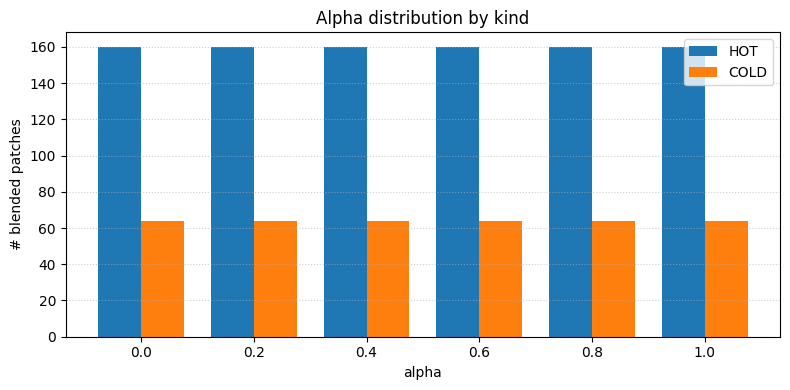

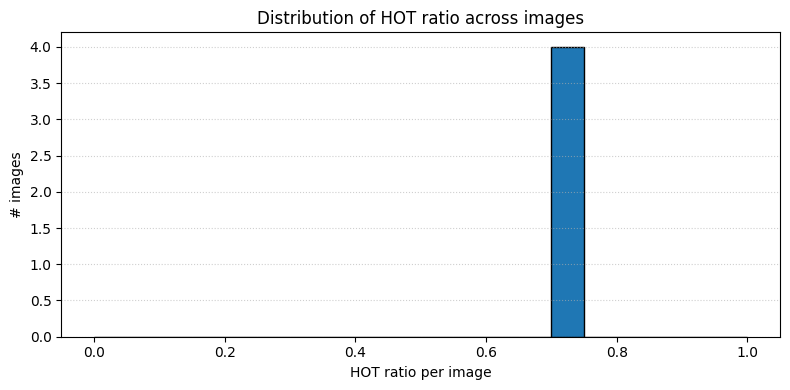

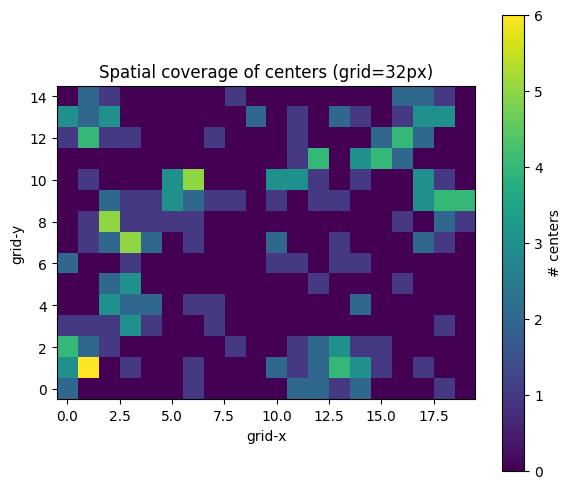

[Files] missing — mixed:0  orig:0  comp:0


In [77]:
# CELL 7 — QA (Method-1: y = 1 − alpha) with 3 informative plots
# ----------------------------------------------------------------
# Purpose
#   Visual sanity-checks for the generated data using three concise plots:
#     (A) Alpha distribution by kind (HOT/COLD)
#     (B) Per-image HOT ratio distribution
#     (C) Spatial coverage of sampled centers (coarse grid heatmap)
#
# Inputs (expected)
#   - {DATASET_DIR}/blends_meta.csv  (from CELL 6)
#   - {DATASET_DIR}/patches_meta.csv (from CELL 5)
#
# Outputs
#   - 3 matplotlib figures; minimal prints for missing files

BLENDS_CSV  = DATASET_DIR / "blends_meta.csv"
PATCHES_CSV = DATASET_DIR / "patches_meta.csv"
assert BLENDS_CSV.exists(),  f"Missing {BLENDS_CSV} (run CELL 6 first)"
assert PATCHES_CSV.exists(), f"Missing {PATCHES_CSV} (run CELL 5 first)"

df_blends  = pd.read_csv(BLENDS_CSV)
df_patches = pd.read_csv(PATCHES_CSV)

# ---------------------------
# A) Alpha distribution by kind
# ---------------------------
# Count blends per alpha and kind (HOT/COLD)
alphas_sorted = sorted(df_blends["alpha"].unique())
kinds = ["hot", "cold"]
counts = {k: [int(((df_blends["alpha"] == a) & (df_blends["kind"] == k)).sum()) for a in alphas_sorted]
          for k in kinds}

x = np.arange(len(alphas_sorted))
width = 0.38

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x - width/2, counts["hot"],  width, label="HOT")
ax.bar(x + width/2, counts["cold"], width, label="COLD")
ax.set_xticks(x, [str(a) for a in alphas_sorted])
ax.set_xlabel("alpha")
ax.set_ylabel("# blended patches")
ax.set_title("Alpha distribution by kind")
ax.legend()
ax.grid(axis="y", linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

# ---------------------------
# B) Per-image HOT ratio distribution
# ---------------------------
# ratio_hot = hot / (hot + cold)
hc_img = df_blends.pivot_table(index="image_id", columns="kind", values="alpha",
                               aggfunc="count", fill_value=0)
hot = hc_img["hot"] if "hot" in hc_img else pd.Series(0, index=hc_img.index)
cold = hc_img["cold"] if "cold" in hc_img else pd.Series(0, index=hc_img.index)
ratio_hot = (hot / (hot + cold + 1e-9)).rename("ratio_hot")

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(ratio_hot.values, bins=np.linspace(0,1,21), edgecolor="black")
ax.set_xlabel("HOT ratio per image")
ax.set_ylabel("# images")
ax.set_title("Distribution of HOT ratio across images")
ax.grid(axis="y", linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

# ---------------------------
# C) Spatial coverage (coarse grid heatmap)
# ---------------------------
# Count how many patch centers fell into each coarse grid cell
grid_step = 32  # increase if your images are large to make it coarser
def _grid_key(x, y, step=grid_step):
    return (int(x)//step, int(y)//step)

occ = Counter(_grid_key(int(x), int(y)) for x, y in zip(df_patches["x"], df_patches["y"]))
if len(occ) > 0:
    grid_df = pd.DataFrame([{"gx": k[0], "gy": k[1], "count": v} for k, v in occ.items()])
    # Normalize grid to full rectangle for heatmap display
    gx_min, gx_max = grid_df["gx"].min(), grid_df["gx"].max()
    gy_min, gy_max = grid_df["gy"].min(), grid_df["gy"].max()
    grid_full = pd.DataFrame(
        [(gx, gy) for gx in range(gx_min, gx_max+1) for gy in range(gy_min, gy_max+1)],
        columns=["gx","gy"]
    ).merge(grid_df, on=["gx","gy"], how="left").fillna({"count":0})
    pivot = grid_full.pivot(index="gy", columns="gx", values="count")

    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(pivot.values, origin="lower", aspect="equal")
    ax.set_title(f"Spatial coverage of centers (grid={grid_step}px)")
    ax.set_xlabel("grid-x")
    ax.set_ylabel("grid-y")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("# centers")
    plt.tight_layout()
    plt.show()
else:
    print("No patch centers found for spatial coverage plot.")

# ---------------------------
# Optional: quick missing-file check (minimal prints, no tables)
# ---------------------------
def _missing(paths):
    return [p for p in paths if isinstance(p, str) and not Path(p).exists()]

miss_mixed = _missing(df_blends.get("mixed_path", pd.Series(dtype=str)).dropna().unique())
miss_orig  = _missing(df_blends.get("orig_path",  pd.Series(dtype=str)).dropna().unique())
miss_comp  = _missing(df_blends.get("comp_path",  pd.Series(dtype=str)).dropna().unique()) \
             if "comp_path" in df_blends.columns else []

print(f"[Files] missing — mixed:{len(miss_mixed)}  orig:{len(miss_orig)}  comp:{len(miss_comp)}")


In [78]:
# CELL 8 — Split by image_id (no leakage) and export CSVs
# -------------------------------------------------------
# Purpose
#   Create train/val/test splits at the image_id level to avoid leakage between splits,
#   then export per-split CSVs from blends_meta.csv (CELL 6 output).
#
# Inputs (expected)
#   - {DATASET_DIR}/blends_meta.csv  with at least: image_id, alpha, y, mixed_path
#
# Outputs
#   - {DATASET_DIR}/blends_train.csv
#   - {DATASET_DIR}/blends_val.csv
#   - {DATASET_DIR}/blends_test.csv
#   - Console sanity prints (counts, disjointness, alpha balance)

from sklearn.model_selection import train_test_split

BLENDS_CSV = DATASET_DIR / "blends_meta.csv"
assert BLENDS_CSV.exists(), f"Missing {BLENDS_CSV}. Run CELL 6 first."

df = pd.read_csv(BLENDS_CSV)

# Unique image IDs
images = sorted(df["image_id"].unique().tolist())

# 15% test, ~15% val (via secondary split of the train pool)
train_ids, test_ids = train_test_split(images, test_size=0.15, random_state=42)
train_ids, val_ids  = train_test_split(train_ids, test_size=0.1765, random_state=42)  # ≈15% of total

print(f"Total images: {len(images)} | Train: {len(train_ids)} | Val: {len(val_ids)} | Test: {len(test_ids)}")

# Helper to subset by image_id
def _subset(df_, ids):
    return df_[df_["image_id"].isin(ids)].reset_index(drop=True)

df_train = _subset(df, train_ids)
df_val   = _subset(df, val_ids)
df_test  = _subset(df, test_ids)

# Assert disjointness (no leakage)
assert set(train_ids).isdisjoint(val_ids)
assert set(train_ids).isdisjoint(test_ids)
assert set(val_ids).isdisjoint(test_ids)

# Save splits
out_train = DATASET_DIR / "blends_train.csv"
out_val   = DATASET_DIR / "blends_val.csv"
out_test  = DATASET_DIR / "blends_test.csv"

df_train.to_csv(out_train, index=False)
df_val.to_csv(out_val, index=False)
df_test.to_csv(out_test, index=False)

print("Saved:")
print(" -", out_train)
print(" -", out_val)
print(" -", out_test)

# Optional sanity on splits (informative, minimal)
print("\nPer-split image counts:")
for name, ids in [("train", train_ids), ("val", val_ids), ("test", test_ids)]:
    print(f"{name}: {len(ids)} images")

if "alpha" in df.columns:
    print("\nPer-split alpha balance:")
    for name, df_ in [("train", df_train), ("val", df_val), ("test", df_test)]:
        print(f"{name}:\n{df_['alpha'].value_counts().sort_index()}")


Total images: 4 | Train: 2 | Val: 1 | Test: 1
Saved:
 - c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\dataset\blends_train.csv
 - c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\dataset\blends_val.csv
 - c:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\dataset\blends_test.csv

Per-split image counts:
train: 2 images
val: 1 images
test: 1 images

Per-split alpha balance:
train:
alpha
0.0    112
0.2    112
0.4    112
0.6    112
0.8    112
1.0    112
Name: count, dtype: int64
val:
alpha
0.0    56
0.2    56
0.4    56
0.6    56
0.8    56
1.0    56
Name: count, dtype: int64
test:
alpha
0.0    56
0.2    56
0.4    56
0.6    56
0.8    56
1.0    56
Name: count, dtype: int64
